<a href="https://colab.research.google.com/github/lowolf25/machine_learning_projects/blob/main/imdb_sentiment_analysis_model_with_neuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setting Environment:

In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting toolkit folder as working directory

%cd /content/drive/MyDrive/Colab Notebooks/Project (1) _ Sentiment Analysis Model
! ls

/content/drive/MyDrive/Colab Notebooks/Project (1) _ Sentiment Analysis Model
c1_lstm_model_acc_0.865.h5	c2_lstm_model_acc_0.863.h5  f2_IMDb_Unseen_Reviews.csv
c2_IMDb_Unseen_Predictions.csv	cnn_model_acc_0.851.h5	    f3_glove.6B.100d.txt
c2_lstm_model_acc_0.852.h5	cnn_model_acc_0.852.h5	    s1_IMDb_Unseen_Predictions.csv
c2_lstm_model_acc_0.854.h5	cnn_model_acc_0.853.h5	    sentiment_analysis_model.ipynb
c2_lstm_model_acc_0.857.h5	f1_IMDB_Dataset.csv


In [ ]:
# Importing libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array


from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## 1. Data Exploration and Preprocessing:

In [ ]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("f1_IMDB_Dataset.csv")

In [ ]:
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [ ]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<ipython-input-19-56b120ffcbd9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=movie_reviews, palette=['green','red'])


<Axes: xlabel='sentiment', ylabel='count'>

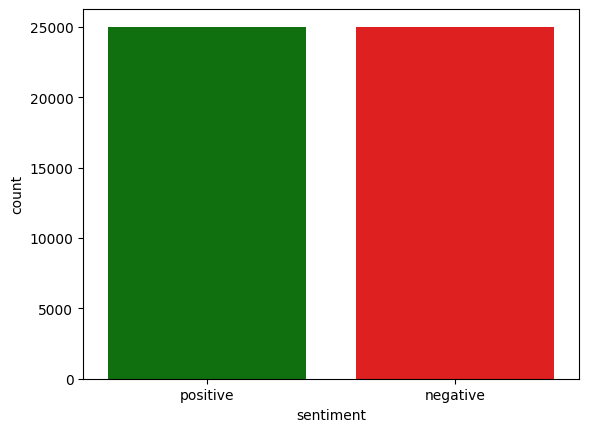

In [ ]:
# Observing distribution of positive and negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews, palette=['green','red'])

In [ ]:
# Ckecking some sample of reviews in the dataset

movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [ ]:
# Building function to Remove HTML tags and replace anything between opening and closing <> with empty space

tag_re = re.compile(r'<[^>]+>')

def remove_tags(text):
    return tag_re.sub('', text)

In [ ]:
# Importing package to Remove Stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# Data Preprocessing

# Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase

def preprocess_text(sen):

    # Convert text to lowercase
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review

X[3]

# As Word Embeddings will be used, stemming/lemmatization is not performed in this preprocessing step

'basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots well playing parents descent dialogs shots jake ignore '

In [ ]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
# Spliting the dataset into training set for model training and testing set for model evaluation.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## 2. Feature Engineering:

 In this stage, Embedding layer will be built using GloVe word embeddings method which converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [ ]:
# Embedding layer in Neural Network expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('f3_glove.6B.100d.txt', encoding="utf8")


for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92394, 100)

# 3. Model Selection and Training:



## Simple Neural Network

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
snn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 6ms/step - loss: 0.5609 - acc: 0.7132 - val_loss: 0.5063 - val_acc: 0.7569
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4492 - acc: 0.7936 - val_loss: 0.4941 - val_acc: 0.7656
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4135 - acc: 0.8142 - val_loss: 0.5019 - val_acc: 0.7648
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3908 - acc: 0.8297 - val_loss: 0.5104 - val_acc: 0.7617
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3757 - acc: 0.8348 - val_loss: 0.5210 - val_acc: 0.7607
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3632 - acc: 0.8427 - val_loss: 0.5309 - val_acc: 0.7575


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5574 - acc: 0.7485


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.557395875453949
Test Accuracy: 0.7484999895095825


In [ ]:
x_test_flattened = X_test.flatten()
for i in range(len(x_test_flattened)):
  if x_test_flattened[i] > 0:
    x_test_flattened[i] = 1
  else:
    x_test_flattened[i] = 0

In [ ]:
import random

# Get the length of the X_test list
x_test_length = len(x_test_flattened)

# Generate a random index between 0 and the length of the X_test list
random_index = random.randint(0, x_test_length - 1)

# Get the sample from the X_test list
x_test_sample = x_test_flattened[random_index]

# # Get the corresponding sample from the y_test list
# y_test_sample = y_test[random_index]

# Print the samples
print(f"Sample of X_test: {x_test_sample}")
# print(f"Sample of y_test: {y_test_sample}")

Sample of X_test: 1


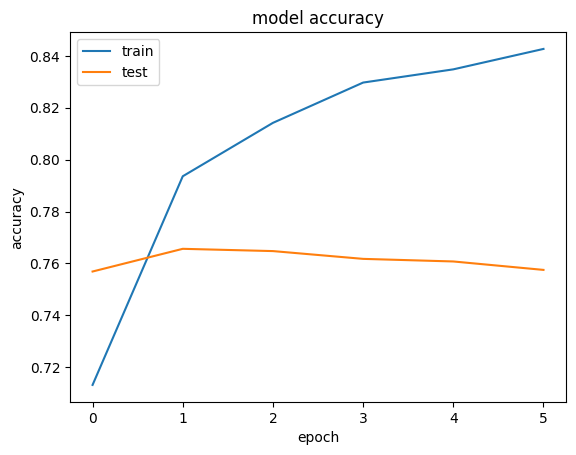

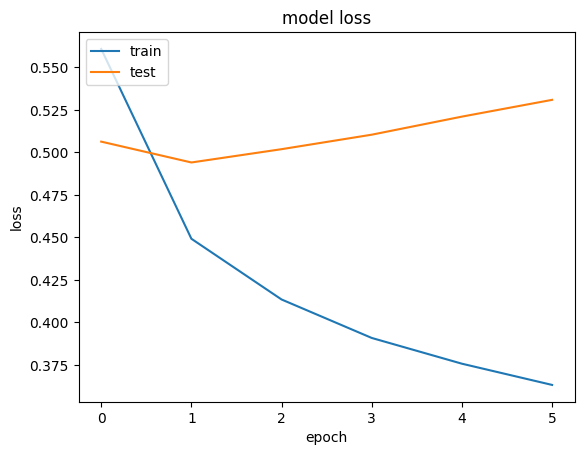

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:

# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 25s 96ms/step - loss: 0.4692 - acc: 0.7765 - val_loss: 0.3822 - val_acc: 0.8324
Epoch 2/6
250/250 [==============================] - 20s 81ms/step - loss: 0.3389 - acc: 0.8561 - val_loss: 0.3508 - val_acc: 0.8465
Epoch 3/6
250/250 [==============================] - 22s 87ms/step - loss: 0.2843 - acc: 0.8870 - val_loss: 0.3380 - val_acc: 0.8516
Epoch 4/6
250/250 [==============================] - 20s 81ms/step - loss: 0.2382 - acc: 0.9119 - val_loss: 0.3340 - val_acc: 0.8540
Epoch 5/6
250/250 [==============================] - 22s 87ms/step - loss: 0.2002 - acc: 0.9317 - val_loss: 0.3317 - val_acc: 0.8558
Epoch 6/6
250/250 [==============================] - 20s 80ms/step - loss: 0.1626 - acc: 0.9532 - val_loss: 0.3352 - val_acc: 0.8559


In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 9ms/step - loss: 0.3433 - acc: 0.8524


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3433106541633606
Test Accuracy: 0.852400004863739


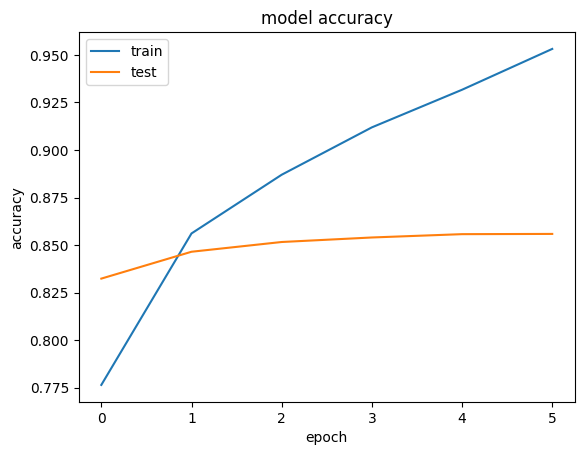

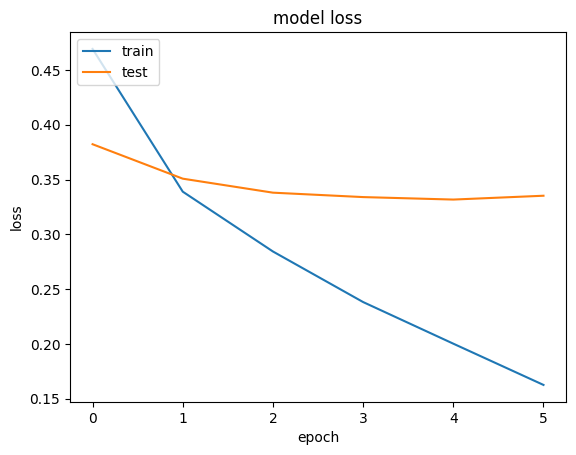

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

cnn_model.save(f"./cnn_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 71s 278ms/step - loss: 0.5233 - acc: 0.7353 - val_loss: 0.4214 - val_acc: 0.8140
Epoch 2/6
250/250 [==============================] - 69s 275ms/step - loss: 0.4115 - acc: 0.8174 - val_loss: 0.3842 - val_acc: 0.8414
Epoch 3/6
250/250 [==============================] - 69s 277ms/step - loss: 0.3716 - acc: 0.8386 - val_loss: 0.3605 - val_acc: 0.8518
Epoch 4/6
250/250 [==============================] - 71s 286ms/step - loss: 0.3458 - acc: 0.8516 - val_loss: 0.3967 - val_acc: 0.8346
Epoch 5/6
250/250 [==============================] - 73s 292ms/step - loss: 0.3303 - acc: 0.8611 - val_loss: 0.3700 - val_acc: 0.8281
Epoch 6/6
250/250 [==============================] - 73s 290ms/step - loss: 0.3099 - acc: 0.8706 - val_loss: 0.3507 - val_acc: 0.8558


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 15s 48ms/step - loss: 0.3558 - acc: 0.8542


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3557969629764557
Test Accuracy: 0.854200005531311


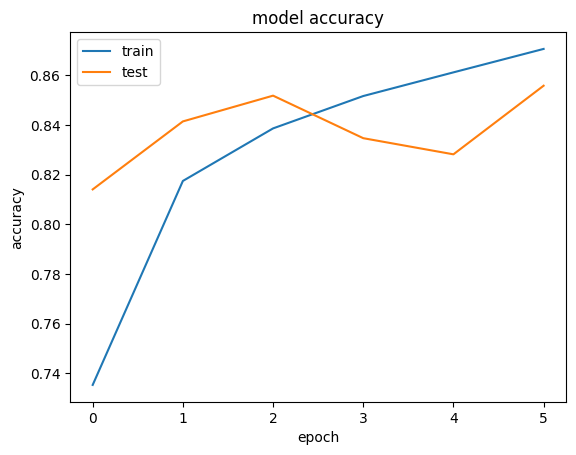

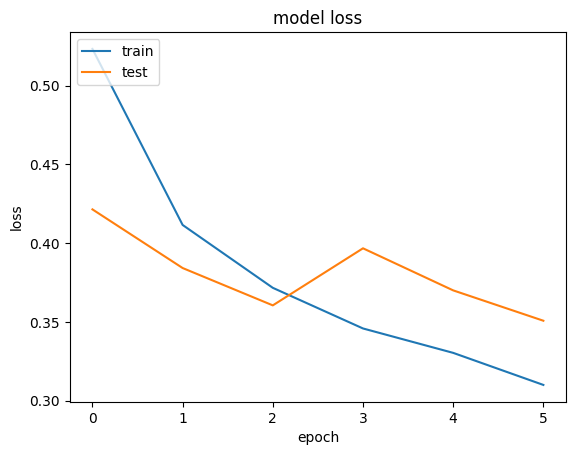

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c2_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [ ]:
# lists files in working directory
!ls

c1_lstm_model_acc_0.865.h5	c2_lstm_model_acc_0.863.h5  f2_IMDb_Unseen_Reviews.csv
c2_IMDb_Unseen_Predictions.csv	cnn_model_acc_0.851.h5	    f3_glove.6B.100d.txt
c2_lstm_model_acc_0.852.h5	cnn_model_acc_0.852.h5	    s1_IMDb_Unseen_Predictions.csv
c2_lstm_model_acc_0.854.h5	cnn_model_acc_0.853.h5	    sentiment_analysis_model.ipynb
c2_lstm_model_acc_0.857.h5	f1_IMDB_Dataset.csv


In [ ]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='./c1_lstm_model_acc_0.865.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.

pretrained_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("f2_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 453ms/step


array([[0.8113427 ],
       [0.9905725 ],
       [0.27007455],
       [0.29110172],
       [0.9166927 ],
       [0.00816861]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.7
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.9
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.2
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1


In [ ]:
# Get user input
user_input = input("Enter your text: ")

# Preprocess the input text
processed_text = preprocess_text(user_input)

# Create a list containing only the processed user input
unseen_processed = [processed_text]
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)


# Print the processed text (optional)
print("Processed text:", unseen_sentiments)

Enter your text: 069148
1/1 [==============================] - 0s 35ms/step
Processed text: [[0.52743065]]


# 4. Model Evaluation


In [ ]:
# Make predictions
predicted_sentiments = pretrained_lstm_model.predict(X_test)

# Convert predicted probabilities to binary values
predicted_sentiments = np.round(predicted_sentiments)

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_sentiments)
precision = precision_score(y_test, predicted_sentiments)
recall = recall_score(y_test, predicted_sentiments)
f1 = f1_score(y_test, predicted_sentiments)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

313/313 [==============================] - 17s 54ms/step
Accuracy: 0.8632
Precision: 0.8530486632044624
Recall: 0.8801349474102005
F1 Score: 0.8663801523735105


<ipython-input-68-8d9a72e373ae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy', 'Precision', 'Recall', 'F1 Score'], y=[accuracy, precision, recall, f1], palette='Set2')


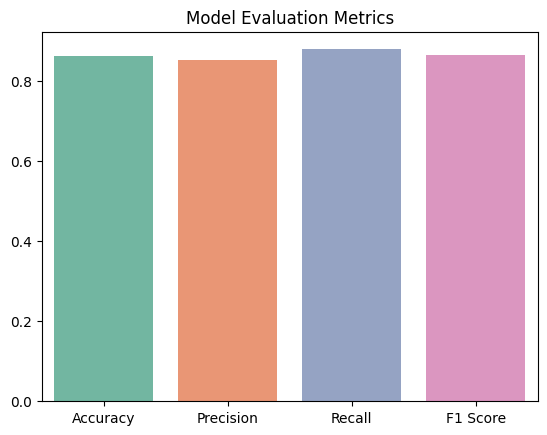

In [ ]:
import seaborn as sns

# Create a bar chart of the evaluation metrics
sns.barplot(x=['Accuracy', 'Precision', 'Recall', 'F1 Score'], y=[accuracy, precision, recall, f1], palette='Set2')
plt.title('Model Evaluation Metrics')
plt.show()

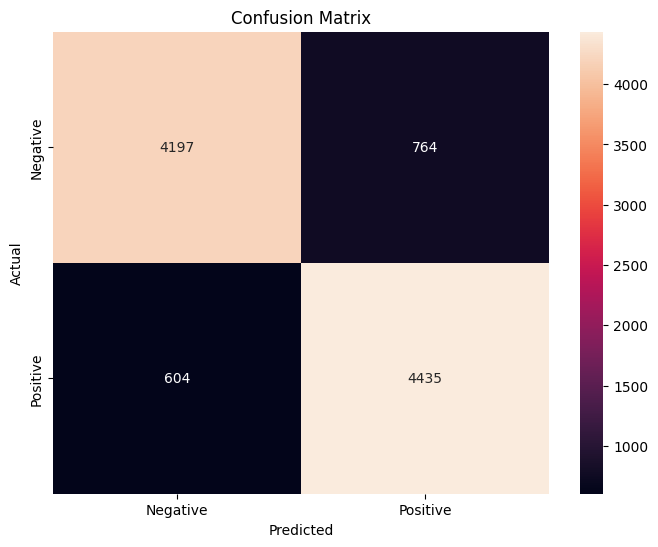

In [ ]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(y_test, predicted_sentiments)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Model Interpretation and Insights:

In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
from getpass import getpass
review = getpass('Enter your review: ')

In [ ]:
import numpy as np

# Ensure that weights and word tokenizer are properly defined
if not hasattr(pretrained_lstm_model, 'get_weights'):
    raise ValueError("The model doesn't have get_weights() method.")

if not hasattr(word_tokenizer, 'word_index'):
    raise ValueError("The word tokenizer doesn't have word_index attribute.")

# Get the model's weights and biases
weights = pretrained_lstm_model.get_weights()[0]

# Convert sequences back into words
reverse_word_index = {v: k for k, v in word_tokenizer.word_index.items()}

# Ensure that unseen_processed is properly preprocessed
if not unseen_processed:
    raise ValueError("unseen_processed is empty.")

# Identify the most important words for positive and negative sentiment
positive_sequences = [{'sequence': seq, 'weight': weight.tolist()} for seq, weight in zip(unseen_processed, weights) if np.any(weight > 0)]
negative_sequences = [{'sequence': seq, 'weight': weight.tolist()} for seq, weight in zip(unseen_processed, weights) if np.any(weight < 0)]

print("Positive sequences:")
for sequence in positive_sequences:
    print("Sequence:", sequence['sequence'])
    print("Weight:", sequence['weight'])
    print()

print("Negative sequences:")
for sequence in negative_sequences:
    print("Sequence:", sequence['sequence'])
    print("Weight:", sequence['weight'])
    print()


Positive sequences:
Sequence: extraordinary thought provoking ex machina surprisingly dense titles alex garland written perhaps excepting annihilation simple concept given definite narrative narrative pointedly explores nature thought perception broaching nature ramifications morality psychological thriller fundamental construction minute rendering alike intense feature genre name offhand much almost classify horror movie emphasizes plays dire uncertainty intent motivation reality way climax even leaves us somewhat ambiguous ending ordinary beginning captivating ending every point ex machina absolutely marvelous performance seen oscar isaac none nearly forceful portrayal nathan exhibiting outstanding nuance sharp personality realization man exceptionally intelligent exceptionally cruel conniving especially familiar domhnall gleeson irish actor demonstrates admirable range poise readily matching traits immediately notable costars said certainly count anyone else involved alicia vikander

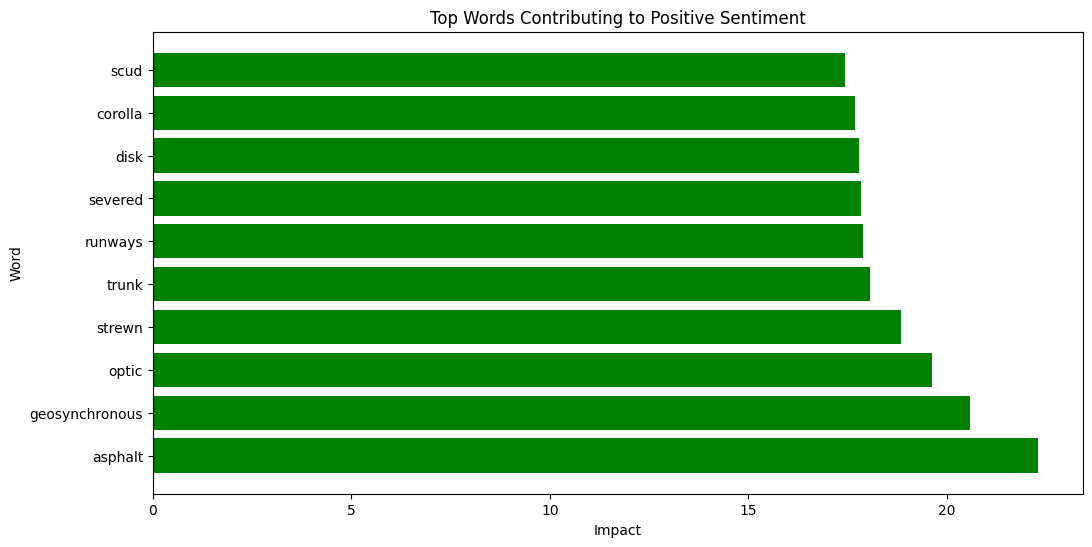

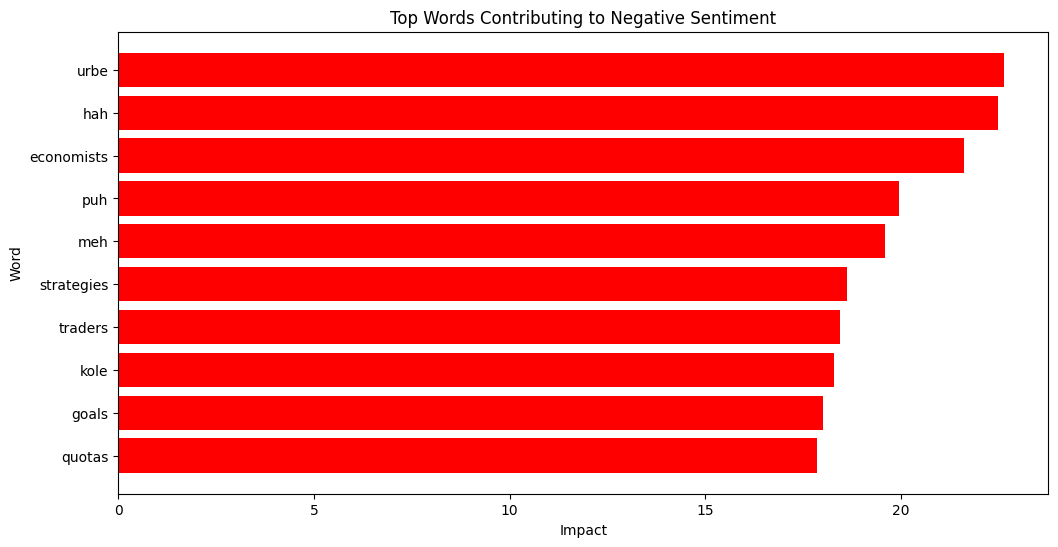

Top Words Contributing to Positive Sentiment:
             Word     Impact
0         asphalt  22.310970
1  geosynchronous  20.582682
2           optic  19.626831
3          strewn  18.852543
4           trunk  18.073881
5         runways  17.886465
6         severed  17.843174
7            disk  17.782692
8         corolla  17.696344
9            scud  17.440338

Top Words Contributing to Negative Sentiment:
         Word     Impact
0      quotas -17.863121
1       goals -18.015985
2        kole -18.277725
3     traders -18.439272
4  strategies -18.630756
5         meh -19.601360
6         puh -19.948648
7  economists -21.601412
8         hah -22.470051
9        urbe -22.634499


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that weights and word tokenizer are properly defined
if not hasattr(pretrained_lstm_model, 'get_weights'):
    raise ValueError("The model doesn't have get_weights() method.")

if not hasattr(word_tokenizer, 'word_index'):
    raise ValueError("The word tokenizer doesn't have word_index attribute.")

# Get the model's weights and biases
weights = pretrained_lstm_model.get_weights()[0]

# Convert sequences back into words
reverse_word_index = {v: k for k, v in word_tokenizer.word_index.items()}

# Initialize dictionaries to store positive and negative word impacts
positive_word_impacts = {}
negative_word_impacts = {}

# Calculate impact of each word based on weights
for i, weight in enumerate(weights):
    word = reverse_word_index.get(i, '')
    if word:
        impact = np.sum(weight)
        if impact > 0:
            positive_word_impacts[word] = impact
        elif impact < 0:
            negative_word_impacts[word] = impact

# Sort words based on their impact for positive and negative sentiments
sorted_positive_words = sorted(positive_word_impacts.items(), key=lambda x: x[1], reverse=True)
sorted_negative_words = sorted(negative_word_impacts.items(), key=lambda x: x[1], reverse=True)

# Create DataFrames to display the top positive and negative words and their impact
top_positive_words_df = pd.DataFrame(sorted_positive_words[:10], columns=['Word', 'Impact'])
top_negative_words_df = pd.DataFrame(sorted_negative_words[-10:], columns=['Word', 'Impact'])

# Visualize important features impacting sentiment predictions
plt.figure(figsize=(12, 6))
plt.barh(top_positive_words_df['Word'], top_positive_words_df['Impact'], color='green')
plt.xlabel('Impact')
plt.ylabel('Word')
plt.title('Top Words Contributing to Positive Sentiment')
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(top_negative_words_df['Word'], -top_negative_words_df['Impact'], color='red')
plt.xlabel('Impact')
plt.ylabel('Word')
plt.title('Top Words Contributing to Negative Sentiment')
plt.show()

# Provide insights into common themes, sentiments, and trends observed in IMDb movie reviews
print("Top Words Contributing to Positive Sentiment:")
print(top_positive_words_df)
print("\nTop Words Contributing to Negative Sentiment:")
print(top_negative_words_df)



# 6. Model Deployment and Integration:

In [ ]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=0d7e6e3d5e15fb8aede6fe53da61bba90916d7216793a1d716fc16be15cf7cc1
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [ ]:
import anvil

In [ ]:
import anvil.server

In [ ]:
anvil.server.connect("server_NVX6IU4IU4D24YMAPF5CLTXH-GMZFRBK4T5WPSSTN")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='./c1_lstm_model_acc_0.865.h5'
pretrained_lstm_model = load_model(model_path)


In [ ]:
from getpass import getpass
review = getpass('Enter your review: ')

In [ ]:
@anvil.server.callable
def predict_sentiment(text):
  # Preprocess the text
  maxlen = 100

  # Preprocess the input text
  processed_text = preprocess_text(text)

  # Create a list containing only the processed user input
  unseen_processed = [processed_text]
  # Tokenising instance with earlier trained tokeniser
  unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

  # Pooling instance to have maxlength of 100 tokens
  unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
  # Passing tokenised instance to the LSTM model for predictions
  unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)


  sentiment = np.round(unseen_sentiments*10).item()

  if sentiment > 5:
    output = "positive"
  else:
    output = "negative"

  print(sentiment)
  return sentiment , output


In [ ]:
anvil.server.wait_forever()


1/1 [==============================] - 1s 517ms/step
0.0
1/1 [==============================] - 0s 33ms/step
10.0
1/1 [==============================] - 0s 31ms/step
10.0
1/1 [==============================] - 0s 34ms/step
9.0
1/1 [==============================] - 0s 36ms/step
5.0
1/1 [==============================] - 0s 39ms/step
3.0
1/1 [==============================] - 0s 34ms/step
10.0
1/1 [==============================] - 0s 34ms/step
0.0
1/1 [==============================] - 0s 38ms/step
9.0
1/1 [==============================] - 0s 37ms/step
8.0
1/1 [==============================] - 0s 37ms/step
0.0
1/1 [==============================] - 0s 34ms/step
6.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 31ms/step
3.0
1/1 [==============================] - 0s 34ms/step
9.0
1/1 [==============================] - 0s 30ms/step
0.0
1/1 [==============================] - 0s 32ms/step
10.0
1/1 [==============================] - 0s 3

KeyboardInterrupt: 